In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from keras import Sequential
from keras.layers import Input, Dense, Dropout, Lambda, Concatenate
from keras.models import Model
from scipy.stats import gaussian_kde
from tensorflow.python.keras import callbacks
from sklearn.preprocessing import StandardScaler
from keras.callbacks import EarlyStopping
import tensorflow as tf
import random

import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
scaler = StandardScaler()

# defined for future development, skipped now
SNR_wco2 = 400
SNR_sco2 = 250


def process_sim_data(profile_file_path, spectral_file_path):
    # Load data from profile.h5
    with h5py.File(profile_file_path, 'r') as file:
        feature = file['feature']['block0_values'][:]

    # Load data from spectral.h5
    with h5py.File(spectral_file_path, 'r') as file:
        spectra = file['spec']['block0_values'][:]

    # Process spectra data
    for i in range(spectra.shape[0]):
        spectra[i, 0:525] = spectra[i, 0:525] / np.mean(spectra[i, 206:216])
        spectra[i, 525:1280] = spectra[i, 525:1280] / np.mean(spectra[i, 811:826])

    # Prepare input features

    # 4 angles and true surface pressure (simulated pressure is idea surface pressure)
    input_feature = np.append(feature[:, 3:7],feature[:, 9:10],axis=1)
    # cos(solar zenith)
    input_feature[:, 2:3] = np.cos(input_feature[:, 2:3])
    # calculate relatvie azimuth, input_feature[:, 0:1] are the satellite zenith angle, ideally = 0
    input_feature[:, 0:1] = np.abs(input_feature[:, 1:2] - input_feature[:, 3:4])
    #delete two azimuth
    input_feature = np.delete(input_feature, [1,3], axis=1)
    # Convert XCO2 units to ppm
    xco2 = feature[:, 10:11]
    xco2_ppm = xco2 * 1e6

    # Add noise to spectra, skipped
    # wco2_noise = np.random.normal(0, spectra[:, 0:525] / SNR_wco2)
    # spectra[:, 0:525] += wco2_noise
    # sco2_noise = np.random.normal(0, spectra[:, 525:1280] / SNR_sco2)
    # spectra[:, 525:1280] += sco2_noise
    return spectra, input_feature, xco2_ppm

spectra, input_feature, xco2_ppm = process_sim_data('profile.h5','spectral.h5')
model_label = '2band_2angle_year_p2p' # retrieval model name
print(spectra.shape)

(60000, 1280)


In [2]:
years = np.zeros([60000,1])
years[:10000] = 2016
years[10000:20000] = 2017
years[20000:30000] = 2018
years[30000:40000] = 2019
years[40000:50000] = 2020
years[50000:60000] = 2021

input_spec = np.append(spectra,input_feature,axis=1)#spectra
input_spec = np.append(input_spec,years,axis=1)


(60000, 1)

In [3]:
def read_file(file_name):
	file = open(file_name)
	X = []
	k = 0
	while 1:
		line = file.readline()
		k = k+1
		if k==420000:
			break
		if not line:
			break
		data = line[:-1].split(',')
		X.append(np.array(data).astype(np.float64))
	X = np.array(X)
	return X

In [4]:
def process_exp_file(file_path):

    
    with h5py.File(file_path, 'r') as h5file:
        x = h5file['x'][:]
        y = h5file['y'][:]
    print(x.shape)
    sample_size = x.shape[0]
    # The same process of preparing input features

    # !!! this surface pressure is prior surface pressure &
    # which is required to Convert to retrieved surface pressure by MLP-P
    feature = np.append(y[:, 4:8],y[:,12:13],axis=1)
    feature[:,2:3] = np.cos(feature[:,2:3])
    feature[:,0:1] = np.abs(feature[:,1:2] - feature[:,3:4])
    feature = np.delete(feature, [1,3], axis=1)
    input_nn = np.append(x, feature, axis=1)
    ouput_nn = y[:, 10:11]
    
    # random sampled
    indices = np.random.choice(input_nn.shape[0], sample_size, replace=False)
    input_feature = input_nn[indices]
    out_xco2 = ouput_nn[indices]
    
    # add year
    year = int(file_path.split('_')[-1].split('.')[0]) + 2000
    input_feature = np.append(input_feature, np.full((sample_size, 1), year), axis=1)
    
    return sample_size, input_feature, out_xco2

file_paths = [
    'oco_test/test_16.h5',
    'oco_test/test_17.h5',
    'oco_test/test_18.h5',
    'oco_test/test_19.h5',
    'oco_test/test_20.h5'
]

input_nn_list = []
xco2_list = []
num_list = []
for file_path,p_path in zip(file_paths,p_paths):
    sample_data_num, sampled_data_in, sampled_data_xco2 = process_exp_file(file_path)
    input_nn_list.append(sampled_data_in)
    xco2_list.append(sampled_data_xco2)
    num_list.append(sample_data_num)

input_nn_pro = np.vstack(input_nn_list)
xco2_pro = np.vstack(xco2_list)
num_pro = np.array(num_list)

print("Input features shape:", input_nn_pro.shape)
print("xco2 shape:", xco2_pro.shape)
print("shape:", num_pro.shape)

(38626, 1280)
(39850, 1280)
(35945, 1280)
(36452, 1280)
(43277, 1280)
Input features shape: (194150, 1284)
xco2 shape: (194150, 1)
shape: (5,)


In [5]:
#predicted_p for prior surface pressure
p_model_label = '2band_2angle_delta_p'

ux = np.loadtxt("nn_p/ux_"+p_model_label+".dat")
sx = np.loadtxt("nn_p/sx_"+p_model_label+".dat")
uy = np.loadtxt("nn_p/uy_"+p_model_label+".dat")
sy = np.loadtxt("nn_p/sy_"+p_model_label+".dat")

input_p = (input_nn_pro - ux)/(sx**0.5)

layer_p=[500,200,50]

n_features = input_p.shape[1]
filepath="nn_p/train_"+p_model_label+".h5"
model = Sequential()
model.add(Dense(layer_p[0], activation='relu', kernel_initializer='he_uniform', input_shape=(n_features,)))
model.add(Dense(layer_p[1], activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(1))
model.load_weights(filepath)

res = model.predict(input_p)
# (38626, 1280)
# (39850, 1280) 78476
# (35945, 1280) 114421
# (36452, 1280) 150873
# (43277, 1280) 194150
output_p = res*(sy**0.5)+uy

input_nn_pro[:,-2:-1] = output_p

6068/6068 [==============================] - 4s 578us/step


In [6]:


scaler.fit(input_spec)  
[ux1,sx1]=[scaler.mean_,scaler.var_]
input_nn_test = scaler.transform(input_nn_pro)
input_nn = scaler.transform(input_spec)

scaler.fit(xco2_ppm)  
[uy1,sy1]=[scaler.mean_,scaler.var_]
output_nn_test = scaler.transform(xco2_pro)
output_nn = scaler.transform(xco2_ppm)

input_nn = np.append(input_nn,input_nn_test[0:38626,:],axis=0)#combined 2016 samples
output_nn = np.append(output_nn,output_nn_test[0:38626,:],axis=0)

np.savetxt("nn/ux_"+model_label+".dat",ux1, fmt="%15.5e",delimiter=',')
np.savetxt("nn/sx_"+model_label+".dat",sx1, fmt="%15.5e",delimiter=',')
np.savetxt("nn/uy_"+model_label+".dat",uy1, fmt="%15.5e",delimiter=',')
np.savetxt("nn/sy_"+model_label+".dat",sy1, fmt="%15.5e",delimiter=',')



In [17]:
train_X, test_X, train_y, test_y = train_test_split(input_nn,output_nn,test_size=0.1, random_state=1)
print(input_nn.shape,output_nn.shape)

from tensorflow.keras.losses import Huber
huber_loss = Huber(delta=1.0)

(98626, 1284) (98626, 1)


In [69]:
layer=[1000,500,300,100,20]
n_features = train_X.shape[1]
filepath="nn/train_"+model_label+".h5"

model = Sequential()
model.add(Dense(layer[0], activation='relu', kernel_initializer='he_uniform', input_shape=(n_features,)))
model.add(Dense(layer[1], activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(layer[2], activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(layer[3], activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(layer[4], activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(output_nn.shape[1]))

model.compile(optimizer='adam', loss=huber_loss,metrics=['mae'])
model.summary()
checkpoint=callbacks.ModelCheckpoint(filepath,monitor='val_loss',verbose=0,save_best_only=True,mode='min')

early_stopping = EarlyStopping(
    monitor='val_loss',   
    patience=20,          
    mode='min',           
    verbose=1             
)

callbacks_list=[checkpoint,early_stopping]
# epoch 20-23 best currently
model.fit(train_X, train_y, epochs=1000, batch_size=128,callbacks=callbacks_list,validation_split=0.1,verbose=1)



Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_93 (Dense)            (None, 1000)              1285000   
                                                                 
 dense_94 (Dense)            (None, 500)               500500    
                                                                 
 dropout_15 (Dropout)        (None, 500)               0         
                                                                 
 dense_95 (Dense)            (None, 300)               150300    
                                                                 
 dense_96 (Dense)            (None, 100)               30100     
                                                                 
 dense_97 (Dense)            (None, 20)                2020      
                                                                 
 dense_98 (Dense)            (None, 1)               

Epoch 1/1000
694/694 [==============================] - 2s 3ms/step - loss: 0.1516 - mae: 0.4162 - val_loss: 0.1270 - val_mae: 0.4030
Epoch 2/1000
694/694 [==============================] - 2s 2ms/step - loss: 0.0785 - mae: 0.2974 - val_loss: 0.1326 - val_mae: 0.4230
Epoch 3/1000
694/694 [==============================] - 2s 2ms/step - loss: 0.0682 - mae: 0.2761 - val_loss: 0.1046 - val_mae: 0.3650
Epoch 4/1000
694/694 [==============================] - 2s 2ms/step - loss: 0.0660 - mae: 0.2706 - val_loss: 0.1302 - val_mae: 0.3972
Epoch 5/1000
694/694 [==============================] - 2s 2ms/step - loss: 0.0624 - mae: 0.2631 - val_loss: 0.1038 - val_mae: 0.3648
Epoch 6/1000
694/694 [==============================] - 2s 2ms/step - loss: 0.0600 - mae: 0.2571 - val_loss: 0.1048 - val_mae: 0.3693
Epoch 7/1000
694/694 [==============================] - 2s 2ms/step - loss: 0.0574 - mae: 0.2509 - val_loss: 0.0974 - val_mae: 0.3557
Epoch 8/1000
694/694 [==============================] - 2s 2ms

309/309 [==============================] - 0s 1ms/step


<Figure size 800x700 with 0 Axes>

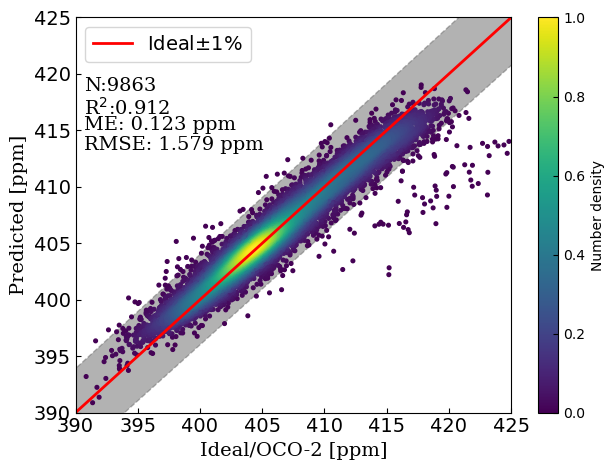

In [88]:
res = model.predict(test_X)
MLP = scaler.inverse_transform(res)
LBL = scaler.inverse_transform(test_y)


def r2(y_true, y_pred):
    """
    Calculation of the unadjusted r-squared, goodness of fit metric
    """
    sse  = np.square( y_pred - y_true ).sum()
    sst  = np.square( y_true - y_true.mean() ).sum()
    return 1 - sse/sst

xy = (np.append(MLP, LBL,axis=1)).T
z = gaussian_kde(xy)(xy)
z=(z-np.min(z))/(np.max(z)-np.min(z))
idx = z.argsort()
MMLP, LLBL, z = MLP[idx], LBL[idx], z[idx]
xyline = np.linspace(0.95*np.min(LBL),1.05*np.max(LBL),61)

fig = plt.figure(figsize=(8,7))
figg,ax = plt.subplots()
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.ylabel('Predicted [ppm]',fontname="serif",fontsize=14)
plt.xlabel('Ideal/OCO-2 [ppm]',fontname="serif",fontsize=14)
plt.axis([390,425,390,425])
text1 = 'N:'+str(len(LBL)) 
text2 = 'R$^2$:'+str("%.3f" % r2(LBL,MLP))
text3 = 'ME: '+str("%.3f" % np.mean(LBL-MLP))+' ppm'
text4 = 'RMSE: '+str("%.3f" % np.sqrt(mean_squared_error(LBL, MLP)))+' ppm'

plt.plot(xyline, xyline, 'r-',label='Ideal$\pm$1%', linewidth=2)
plt.fill_between(xyline, xyline*1.01, xyline*0.99,
    alpha=0.5, edgecolor='0.4', facecolor='0.4',
    linewidth=1, linestyle='--', antialiased=True)
plt.scatter(LLBL, MMLP, c=z,s=7, alpha=1.0)#facecolors='none',
plt.colorbar(label='Number density')
plt.tick_params(labelsize=14)
plt.legend(fontsize=14)
plt.ticklabel_format(style='plain', scilimits=(0, 0), axis='both')
plt.text(0.02,0.85,text1,ha='left',va='top',transform=ax.transAxes,fontname="serif",fontsize=14)
plt.text(0.02,0.80,text2,ha='left',va='top',transform=ax.transAxes,fontname="serif",fontsize=14)
plt.text(0.02,0.75,text3,ha='left',va='top',transform=ax.transAxes,fontname="serif",fontsize=14)
plt.text(0.02,0.70,text4,ha='left',va='top',transform=ax.transAxes,fontname="serif",fontsize=14)
plt.tight_layout()
plt.show()


1208/1208 [==============================] - 1s 874us/step


<Figure size 800x700 with 0 Axes>

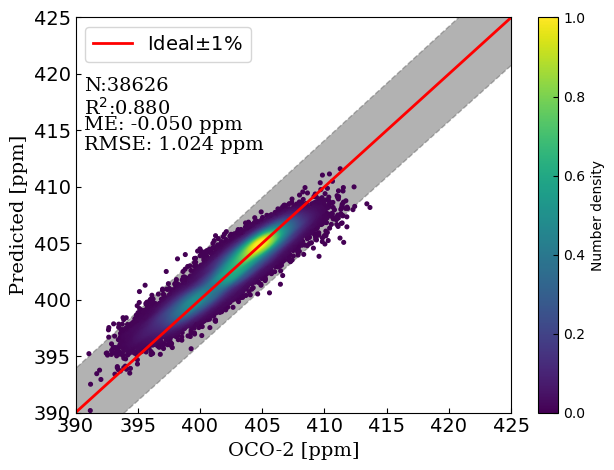

In [87]:

# (38626, 1280)
# (39850, 1280) 78476
# (35945, 1280) 114421
# (36452, 1280) 150873
# (43277, 1280) 194150


res = model.predict(input_nn_test[:38626])
MLP = scaler.inverse_transform(res)
LBL = scaler.inverse_transform(output_nn_test[:38626])
def r2(y_true, y_pred):
    """
    Calculation of the unadjusted r-squared, goodness of fit metric
    """
    sse  = np.square( y_pred - y_true ).sum()
    sst  = np.square( y_true - y_true.mean() ).sum()
    return 1 - sse/sst

xy = (np.append(MLP, LBL,axis=1)).T
z = gaussian_kde(xy)(xy)
z=(z-np.min(z))/(np.max(z)-np.min(z))
idx = z.argsort()
MMLP, LLBL, z = MLP[idx], LBL[idx], z[idx]
xyline = np.linspace(0.95*np.min(LBL),1.05*np.max(LBL),61)

fig = plt.figure(figsize=(8,7))
figg,ax = plt.subplots()
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.ylabel('Predicted [ppm]',fontname="serif",fontsize=14)
plt.xlabel('OCO-2 [ppm]',fontname="serif",fontsize=14)
plt.axis([390,425,390,425])
text1 = 'N:'+str(len(LBL)) 
text2 = 'R$^2$:'+str("%.3f" % r2(LBL,MLP))
text3 = 'ME: '+str("%.3f" % np.mean(LBL-MLP))+' ppm'
text4 = 'RMSE: '+str("%.3f" % np.sqrt(mean_squared_error(LBL, MLP)))+' ppm'
plt.plot(xyline, xyline, 'r-',label='Ideal$\pm$1%', linewidth=2)
plt.fill_between(xyline, xyline*1.01, xyline*0.99,
    alpha=0.5, edgecolor='0.4', facecolor='0.4',
    linewidth=1, linestyle='--', antialiased=True)
plt.scatter(LLBL, MMLP, c=z,s=7, alpha=1.0)#facecolors='none',
plt.colorbar(label='Number density')
plt.tick_params(labelsize=14)
plt.legend(fontsize=14)
plt.ticklabel_format(style='plain', scilimits=(0, 0), axis='both')
plt.text(0.02,0.85,text1,ha='left',va='top',transform=ax.transAxes,fontname="serif",fontsize=14)
plt.text(0.02,0.80,text2,ha='left',va='top',transform=ax.transAxes,fontname="serif",fontsize=14)
plt.text(0.02,0.75,text3,ha='left',va='top',transform=ax.transAxes,fontname="serif",fontsize=14)
plt.text(0.02,0.70,text4,ha='left',va='top',transform=ax.transAxes,fontname="serif",fontsize=14)
plt.tight_layout()
plt.show()


1246/1246 [==============================] - 1s 780us/step


<Figure size 800x700 with 0 Axes>

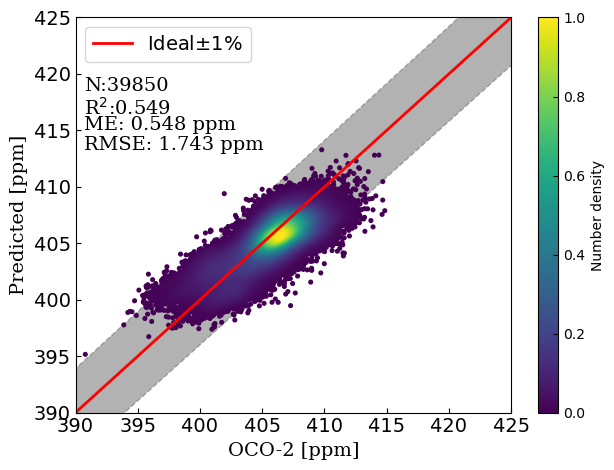

In [89]:
# (38626, 1280)
# (39850, 1280) 78476
# (35945, 1280) 114421
# (36452, 1280) 150873
# (43277, 1280) 194150

# testing data for 2017 future samples
res = model.predict(input_nn_test[38626:78476])
MLP = scaler.inverse_transform(res)
LBL = scaler.inverse_transform(output_nn_test[38626:78476])
def r2(y_true, y_pred):
    """
    Calculation of the unadjusted r-squared, goodness of fit metric
    """
    sse  = np.square( y_pred - y_true ).sum()
    sst  = np.square( y_true - y_true.mean() ).sum()
    return 1 - sse/sst

xy = (np.append(MLP, LBL,axis=1)).T
z = gaussian_kde(xy)(xy)
z=(z-np.min(z))/(np.max(z)-np.min(z))
idx = z.argsort()
MMLP, LLBL, z = MLP[idx], LBL[idx], z[idx]
xyline = np.linspace(0.95*np.min(LBL),1.05*np.max(LBL),61)

fig = plt.figure(figsize=(8,7))
figg,ax = plt.subplots()
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.ylabel('Predicted [ppm]',fontname="serif",fontsize=14)
plt.xlabel('OCO-2 [ppm]',fontname="serif",fontsize=14)
plt.axis([390,425,390,425])
text1 = 'N:'+str(len(LBL)) 
text2 = 'R$^2$:'+str("%.3f" % r2(LBL,MLP))
text3 = 'ME: '+str("%.3f" % np.mean(LBL-MLP))+' ppm'
text4 = 'RMSE: '+str("%.3f" % np.sqrt(mean_squared_error(LBL, MLP)))+' ppm'
plt.plot(xyline, xyline, 'r-',label='Ideal$\pm$1%', linewidth=2)
plt.fill_between(xyline, xyline*1.01, xyline*0.99,
    alpha=0.5, edgecolor='0.4', facecolor='0.4',
    linewidth=1, linestyle='--', antialiased=True)
plt.scatter(LLBL, MMLP, c=z,s=7, alpha=1.0)#facecolors='none',
plt.colorbar(label='Number density')
plt.tick_params(labelsize=14)
plt.legend(fontsize=14)
plt.ticklabel_format(style='plain', scilimits=(0, 0), axis='both')
plt.text(0.02,0.85,text1,ha='left',va='top',transform=ax.transAxes,fontname="serif",fontsize=14)
plt.text(0.02,0.80,text2,ha='left',va='top',transform=ax.transAxes,fontname="serif",fontsize=14)
plt.text(0.02,0.75,text3,ha='left',va='top',transform=ax.transAxes,fontname="serif",fontsize=14)
plt.text(0.02,0.70,text4,ha='left',va='top',transform=ax.transAxes,fontname="serif",fontsize=14)
plt.tight_layout()
plt.show()

1124/1124 [==============================] - 1s 838us/step


<Figure size 800x700 with 0 Axes>

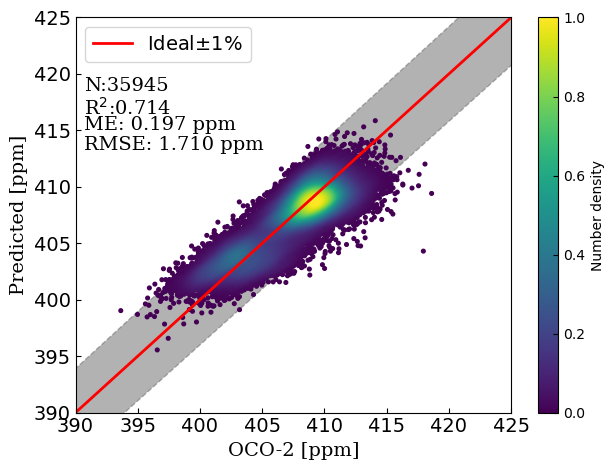

In [90]:
# (38626, 1280)
# (39850, 1280) 78476
# (35945, 1280) 114421
# (36452, 1280) 150873
# (43277, 1280) 194150

# testing data for 2018 future samples
res = model.predict(input_nn_test[78476:114421])
MLP = scaler.inverse_transform(res)
LBL = scaler.inverse_transform(output_nn_test[78476:114421])
def r2(y_true, y_pred):
    """
    Calculation of the unadjusted r-squared, goodness of fit metric
    """
    sse  = np.square( y_pred - y_true ).sum()
    sst  = np.square( y_true - y_true.mean() ).sum()
    return 1 - sse/sst

xy = (np.append(MLP, LBL,axis=1)).T
z = gaussian_kde(xy)(xy)
z=(z-np.min(z))/(np.max(z)-np.min(z))
idx = z.argsort()
MMLP, LLBL, z = MLP[idx], LBL[idx], z[idx]
xyline = np.linspace(0.95*np.min(LBL),1.05*np.max(LBL),61)

fig = plt.figure(figsize=(8,7))
figg,ax = plt.subplots()
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.ylabel('Predicted [ppm]',fontname="serif",fontsize=14)
plt.xlabel('OCO-2 [ppm]',fontname="serif",fontsize=14)
plt.axis([390,425,390,425])
text1 = 'N:'+str(len(LBL)) 
text2 = 'R$^2$:'+str("%.3f" % r2(LBL,MLP))
text3 = 'ME: '+str("%.3f" % np.mean(LBL-MLP))+' ppm'
text4 = 'RMSE: '+str("%.3f" % np.sqrt(mean_squared_error(LBL, MLP)))+' ppm'
plt.plot(xyline, xyline, 'r-',label='Ideal$\pm$1%', linewidth=2)
plt.fill_between(xyline, xyline*1.01, xyline*0.99,
    alpha=0.5, edgecolor='0.4', facecolor='0.4',
    linewidth=1, linestyle='--', antialiased=True)
plt.scatter(LLBL, MMLP, c=z,s=7, alpha=1.0)#facecolors='none',
plt.colorbar(label='Number density')
plt.tick_params(labelsize=14)
plt.legend(fontsize=14)
plt.ticklabel_format(style='plain', scilimits=(0, 0), axis='both')
plt.text(0.02,0.85,text1,ha='left',va='top',transform=ax.transAxes,fontname="serif",fontsize=14)
plt.text(0.02,0.80,text2,ha='left',va='top',transform=ax.transAxes,fontname="serif",fontsize=14)
plt.text(0.02,0.75,text3,ha='left',va='top',transform=ax.transAxes,fontname="serif",fontsize=14)
plt.text(0.02,0.70,text4,ha='left',va='top',transform=ax.transAxes,fontname="serif",fontsize=14)
plt.tight_layout()
plt.show()

1140/1140 [==============================] - 1s 911us/step


<Figure size 800x700 with 0 Axes>

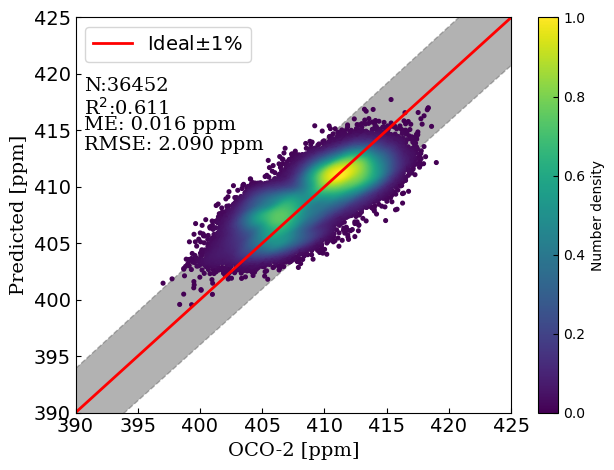

In [91]:
# (38626, 1280)
# (39850, 1280) 78476
# (35945, 1280) 114421
# (36452, 1280) 150873
# (43277, 1280) 194150

# testing data for 2019 future samples
res = model.predict(input_nn_test[114421:150873])
MLP = scaler.inverse_transform(res)
LBL = scaler.inverse_transform(output_nn_test[114421:150873])
def r2(y_true, y_pred):
    """
    Calculation of the unadjusted r-squared, goodness of fit metric
    """
    sse  = np.square( y_pred - y_true ).sum()
    sst  = np.square( y_true - y_true.mean() ).sum()
    return 1 - sse/sst

xy = (np.append(MLP, LBL,axis=1)).T
z = gaussian_kde(xy)(xy)
z=(z-np.min(z))/(np.max(z)-np.min(z))
idx = z.argsort()
MMLP, LLBL, z = MLP[idx], LBL[idx], z[idx]
xyline = np.linspace(0.95*np.min(LBL),1.05*np.max(LBL),61)

fig = plt.figure(figsize=(8,7))
figg,ax = plt.subplots()
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.ylabel('Predicted [ppm]',fontname="serif",fontsize=14)
plt.xlabel('OCO-2 [ppm]',fontname="serif",fontsize=14)
plt.axis([390,425,390,425])
text1 = 'N:'+str(len(LBL)) 
text2 = 'R$^2$:'+str("%.3f" % r2(LBL,MLP))
text3 = 'ME: '+str("%.3f" % np.mean(LBL-MLP))+' ppm'
text4 = 'RMSE: '+str("%.3f" % np.sqrt(mean_squared_error(LBL, MLP)))+' ppm'
plt.plot(xyline, xyline, 'r-',label='Ideal$\pm$1%', linewidth=2)
plt.fill_between(xyline, xyline*1.01, xyline*0.99,
    alpha=0.5, edgecolor='0.4', facecolor='0.4',
    linewidth=1, linestyle='--', antialiased=True)
plt.scatter(LLBL, MMLP, c=z,s=7, alpha=1.0)#facecolors='none',
plt.colorbar(label='Number density')
plt.tick_params(labelsize=14)
plt.legend(fontsize=14)
plt.ticklabel_format(style='plain', scilimits=(0, 0), axis='both')
plt.text(0.02,0.85,text1,ha='left',va='top',transform=ax.transAxes,fontname="serif",fontsize=14)
plt.text(0.02,0.80,text2,ha='left',va='top',transform=ax.transAxes,fontname="serif",fontsize=14)
plt.text(0.02,0.75,text3,ha='left',va='top',transform=ax.transAxes,fontname="serif",fontsize=14)
plt.text(0.02,0.70,text4,ha='left',va='top',transform=ax.transAxes,fontname="serif",fontsize=14)
plt.tight_layout()
plt.show()

1353/1353 [==============================] - 1s 864us/step


<Figure size 800x700 with 0 Axes>

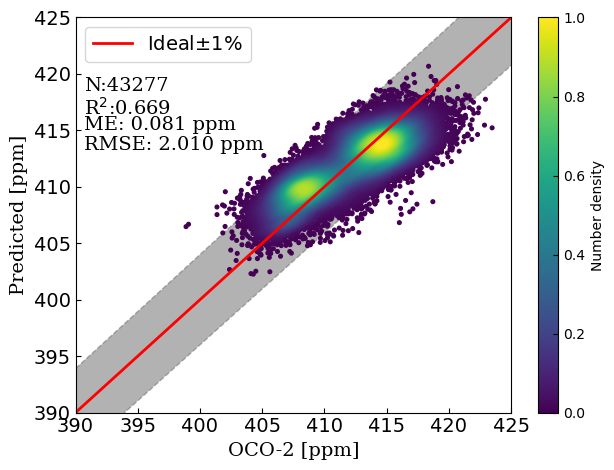

In [92]:

# (38626, 1280)
# (39850, 1280) 78476
# (35945, 1280) 114421
# (36452, 1280) 150873
# (43277, 1280) 194150

# testing data for 2020 future samples
res = model.predict(input_nn_test[150873:194150])
MLP = scaler.inverse_transform(res)
LBL = scaler.inverse_transform(output_nn_test[150873:194150])
def r2(y_true, y_pred):
    """
    Calculation of the unadjusted r-squared, goodness of fit metric
    """
    sse  = np.square( y_pred - y_true ).sum()
    sst  = np.square( y_true - y_true.mean() ).sum()
    return 1 - sse/sst

xy = (np.append(MLP, LBL,axis=1)).T
z = gaussian_kde(xy)(xy)
z=(z-np.min(z))/(np.max(z)-np.min(z))
idx = z.argsort()
MMLP, LLBL, z = MLP[idx], LBL[idx], z[idx]
xyline = np.linspace(0.95*np.min(LBL),1.05*np.max(LBL),61)

fig = plt.figure(figsize=(8,7))
figg,ax = plt.subplots()
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.ylabel('Predicted [ppm]',fontname="serif",fontsize=14)
plt.xlabel('OCO-2 [ppm]',fontname="serif",fontsize=14)
plt.axis([390,425,390,425])
text1 = 'N:'+str(len(LBL)) 
text2 = 'R$^2$:'+str("%.3f" % r2(LBL,MLP))
text3 = 'ME: '+str("%.3f" % np.mean(LBL-MLP))+' ppm'
text4 = 'RMSE: '+str("%.3f" % np.sqrt(mean_squared_error(LBL, MLP)))+' ppm'
plt.plot(xyline, xyline, 'r-',label='Ideal$\pm$1%', linewidth=2)
plt.fill_between(xyline, xyline*1.01, xyline*0.99,
    alpha=0.5, edgecolor='0.4', facecolor='0.4',
    linewidth=1, linestyle='--', antialiased=True)
plt.scatter(LLBL, MMLP, c=z,s=7, alpha=1.0)#facecolors='none',
plt.colorbar(label='Number density')
plt.tick_params(labelsize=14)
plt.legend(fontsize=14)
plt.ticklabel_format(style='plain', scilimits=(0, 0), axis='both')
plt.text(0.02,0.85,text1,ha='left',va='top',transform=ax.transAxes,fontname="serif",fontsize=14)
plt.text(0.02,0.80,text2,ha='left',va='top',transform=ax.transAxes,fontname="serif",fontsize=14)
plt.text(0.02,0.75,text3,ha='left',va='top',transform=ax.transAxes,fontname="serif",fontsize=14)
plt.text(0.02,0.70,text4,ha='left',va='top',transform=ax.transAxes,fontname="serif",fontsize=14)
plt.tight_layout()
plt.show()